In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import jit

In [3]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [4]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [6]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [7]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [8]:
stdampall_ad = np.load('../features/stdampall_ad.npy')
stdampq2_ad = np.load('../features/stdampq2_ad.npy')
stdampq3_ad = np.load('../features/stdampq3_ad.npy')
stdampq4_ad = np.load('../features/stdampq4_ad.npy')

meanampall_ad = np.load('../features/meanampall_ad.npy')
meanampq2_ad = np.load('../features/meanampq2_ad.npy')
meanampq3_ad = np.load('../features/meanampq3_ad.npy')
meanampq4_ad = np.load('../features/meanampq4_ad.npy')

meanamppos = np.load('../features/meanamppos.npy')
meanampneg = np.load('../features/meanampneg.npy')


In [9]:
numpeaks_id = np.load('../features/numpeaks_id.npy')
numpospeaks_id = np.load('../features/numpospeaks_id.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id .npy')

maxamp_id = np.load('../features/maxamp_id.npy')
minamp_id = np.load('../features/minamp_id.npy')
meanamp_id = np.load('../features/meanamp_id.npy')

meanamppos_id = np.load('../features/meanamppos_id.npy')
meanampneg_id = np.load('../features/meanampneg_id.npy')


In [10]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id, 'NumPosPeaks_ID':numpospeaks_id, 'NumNegPeaks_ID':numnegpeaks_id,
                        'MaxAmp_ID':maxamp_id, 'MinAmp_ID':minamp_id, 'MeanAmp_ID':meanamp_id,
                        'MeanAmpPos_ID':meanamppos_id, 'MeanAmpNeg_ID':meanampneg_id})

In [11]:
train = pd.concat([meta_train, train_features], axis=1)

In [12]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg,NumPeaks_ID,NumPosPeaks_ID,NumNegPeaks_ID,MaxAmp_ID,MinAmp_ID,MeanAmp_ID,MeanAmpPos_ID,MeanAmpNeg_ID
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428,44.891664,0.670594,85.296720,24.976989,4.062346,0.000151,14.999402,1.249880,11.181670,-10.294509,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461,30.568193,35.273220,43.143698,24.977523,1.875258,2.500917,3.750465,1.249668,8.331531,-8.799846,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683,30.570660,43.144629,35.274377,24.978110,1.875325,3.750685,2.500106,1.250578,9.514662,-10.973763,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391,87.000132,60.780813,70.004487,43.144785,15.624495,7.500015,9.998660,3.750652,8.910585,-6.666027,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139,84.430994,60.780715,65.567084,24.979410,14.686710,7.499892,8.748330,1.249292,3.898276,-3.984866,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788


In [13]:
signal_id = train['signal_id'].values
del train['signal_id']

In [14]:
target = train['target'].values
del train['target']

In [15]:
from sklearn.metrics import matthews_corrcoef

In [16]:
kf = KFold(n_splits=4, random_state=123, shuffle=False)

In [17]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=False)

[1]	valid_0's MCC: 0.584037
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.620043
[3]	valid_0's MCC: 0.643477
[4]	valid_0's MCC: 0.634613
[5]	valid_0's MCC: 0.644869
[6]	valid_0's MCC: 0.64005
[7]	valid_0's MCC: 0.642332
[8]	valid_0's MCC: 0.645209
[9]	valid_0's MCC: 0.645002
[10]	valid_0's MCC: 0.640718
[11]	valid_0's MCC: 0.644844
[12]	valid_0's MCC: 0.637956
[13]	valid_0's MCC: 0.635584
[14]	valid_0's MCC: 0.637658
[15]	valid_0's MCC: 0.640549
[16]	valid_0's MCC: 0.643474
[17]	valid_0's MCC: 0.638652
[18]	valid_0's MCC: 0.643474
[19]	valid_0's MCC: 0.643474
[20]	valid_0's MCC: 0.643474
[21]	valid_0's MCC: 0.643474
[22]	valid_0's MCC: 0.640156
[23]	valid_0's MCC: 0.6459
[24]	valid_0's MCC: 0.643474
[25]	valid_0's MCC: 0.644053
[26]	valid_0's MCC: 0.649425
[27]	valid_0's MCC: 0.652453
[28]	valid_0's MCC: 0.652453
[29]	valid_0's MCC: 0.647085
[30]	valid_0's MCC: 0.647085
[31]	valid_0's MCC: 0.650153
[32]	valid_0's MCC: 0.650153
[33]	valid_0's MCC: 0.

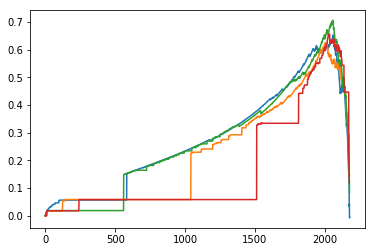

In [18]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in skf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [19]:
proba

[0.5352175577546778,
 0.2132643061233831,
 0.3934025315738686,
 0.09799143332580877]

In [43]:
np.mean(proba)

0.30996895719443457

In [20]:
val_mcc

[0.6524533385543584, 0.6255475272015649, 0.7058204260827242, 0.655637328773262]

In [21]:
np.mean(val_mcc)

0.6598646551529774

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(proba)).astype(int))

array([[8012,  175],
       [ 206,  319]])

0.6142067777008628 0.6142067777008628


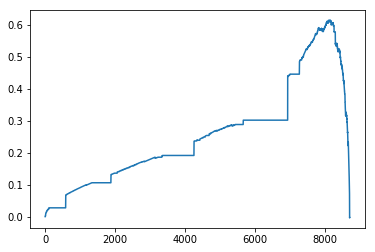

In [23]:
best_proba, best_mcc, y_pred = eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [24]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks_ID,4689.305244
MeanAmpPos_ID,1810.870682
MinAmp_ID,786.437344
MeanAmpNeg_ID,493.420268
NumPosPeaks_ID,423.060031
NumPeaks_ID,307.580162
MaxAmp_ID,250.410897
MeanAmp_ID,203.218486
id_measurement,164.292158
MeanAmpAll_AD,156.759084


In [25]:
feature_imp = []
for model in clf:
    feature_imp.append(model.feature_importance(importance_type='gain'))

pd.DataFrame(feature_imp, columns=train.columns).T.sort_values(by=0, ascending=False)

,0,1,2,3
NumNegPeaks_ID,5275.687959,5040.950312,4520.996848,3919.585858
MeanAmpPos_ID,2198.617612,1823.419934,1610.410263,1611.034918
NumPosPeaks_ID,861.148835,290.243414,345.218479,195.629396
MinAmp_ID,844.013899,936.480276,1267.547701,97.707500
MeanAmpNeg_ID,459.157624,550.900786,745.530667,218.091995
NumPeaks_ID,289.287010,383.148641,557.884997,0.000000
id_measurement,253.980969,171.619060,145.958700,85.609901
MeanAmpAll_AD,248.749104,57.751500,117.490130,203.045601
MeanAmp_ID,243.424179,156.232052,330.359415,82.858299
MaxAmp_ID,206.356990,108.533902,545.582798,141.169897


In [26]:
best_proba

0.22948704169682632

In [27]:
numpeaks = np.load('../features/numpeaks_test.npy')
numpospeaks = np.load('../features/numpospeaks_test.npy')
numnegpeaks = np.load('../features/numnegpeaks_test.npy')

maxpeakwidth = np.load('../features/maxpeakwidth_test.npy')
minpeakwidth = np.load('../features/minpeakwidth_test.npy')
meanpeakwidth = np.load('../features/meanpeakwidth_test.npy')
maxamp = np.load('../features/maxamp_test.npy')
minamp = np.load('../features/minamp_test.npy')
meanamp = np.load('../features/meanamp_test.npy')

stdampall = np.load('../features/stdampall_test.npy')
stdposall = np.load('../features/stdposall_test.npy')
stdwidthall = np.load('../features/stdwidthall_test.npy')

stdampq2 = np.load('../features/stdampq2_test.npy')
stdposq2 = np.load('../features/stdposq2_test.npy')
stdwidthq2 = np.load('../features/stdwidthq2_test.npy')
stdampq3 = np.load('../features/stdampq3_test.npy')
stdposq3 = np.load('../features/stdposq3_test.npy')
stdwidthq3 = np.load('../features/stdwidthq3_test.npy')
stdampq4 = np.load('../features/stdampq4_test.npy')
stdposq4 = np.load('../features/stdposq4_test.npy')
stdwidthq4 = np.load('../features/stdwidthq4_test.npy')


In [28]:
stdampall_ad = np.load('../features/stdampall_ad_test.npy')
stdampq2_ad = np.load('../features/stdampq2_ad_test.npy')
stdampq3_ad = np.load('../features/stdampq3_ad_test.npy')
stdampq4_ad = np.load('../features/stdampq4_ad_test.npy')

meanampall_ad = np.load('../features/meanampall_ad_test.npy')
meanampq2_ad = np.load('../features/meanampq2_ad_test.npy')
meanampq3_ad = np.load('../features/meanampq3_ad_test.npy')
meanampq4_ad = np.load('../features/meanampq4_ad_test.npy')

meanamppos = np.load('../features/meanamppos_test.npy')
meanampneg = np.load('../features/meanampneg_test.npy')


In [29]:
numpeaks_id = np.load('../features/numpeaks_id_test.npy')
numpospeaks_id = np.load('../features/numpospeaks_id_test.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id_test.npy')

maxamp_id = np.load('../features/maxamp_id_test.npy')
minamp_id = np.load('../features/minamp_id_test.npy')
meanamp_id = np.load('../features/meanamp_id_test.npy')

meanamppos_id = np.load('../features/meanamppos_id_test.npy')
meanampneg_id = np.load('../features/meanampneg_id_test.npy')


In [30]:
test_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id[0:20000], 'NumPosPeaks_ID':numpospeaks_id[0:20000], 'NumNegPeaks_ID':numnegpeaks_id[0:20000],
                        'MaxAmp_ID':maxamp_id[0:20000], 'MinAmp_ID':minamp_id[0:20000], 'MeanAmp_ID':meanamp_id[0:20000],
                        'MeanAmpPos_ID':meanamppos_id[0:20000], 'MeanAmpNeg_ID':meanampneg_id[0:20000]})

In [31]:
test = pd.concat([meta_test, test_features], axis=1)

In [32]:
test_id = test['signal_id'].values
del test['signal_id']

In [33]:
preds = None
for model in clf:
    if preds is None:
        preds = model.predict(test)
    else:
        preds += model.predict(test)
    
preds = preds/4

In [34]:
submission = pd.DataFrame({'signal_id':test_id,'target':(preds>best_proba).astype(int)})

In [35]:
submission.to_csv('../output/submission_11.csv', index=False)

In [40]:
pd.Series((preds>best_proba).astype(int)).value_counts()

0    20337
dtype: int64

In [42]:
np.max(preds)

0.1872985914659039

In [51]:
pd.Series((preds>0.077).astype(int)).value_counts()

0    20121
1      216
dtype: int64